# Model Partitioning Statistics and Scaling Analysis

This notebook analyzes the parameter composition of sparse and dense components in large language models, focusing on how model dimension, number of layers, and expert count affect total parameter count and distribution. It visualizes scaling trends and provides summary statistics for model design decisions.

Logging is used throughout for reproducibility and clarity, following best practices from related notebooks.

## Notebook Structure

- **Functions**: Parameter calculation utilities for dense, sparse, and total components.
- **Base Configuration**: Default model hyperparameters.
- **Scaling Analyses**:
    - By model dimension (`d_model`)
    - By number of layers (`n_layers`)
    - Combined scaling (`d_model`, `n_layers`)
- **Visualizations**: Plots for each scaling analysis.
- **Logging**: All results and statistics are logged for reproducibility.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import logging

# Configure logging for the notebook
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger("model_partitioning_stats")


def get_dense_components(d_model: int, vocab_size: int, n_layers: int) -> int:
    """Calculate the number of parameters in the dense components of the model.

    Args:
        d_model (int): Model dimension.
        vocab_size (int): Vocabulary size.
        n_layers (int): Number of layers.

    Returns:
        int: Total dense parameters.

    """
    # Assuming d_heads = d_model / n_heads
    return d_model * vocab_size + n_layers * 4 * d_model * d_model


def get_sparse_components(d_model: int, n_layers: int, n_experts: int) -> int:
    """Calculate the number of parameters in the sparse components of the model.

    Args:
        d_model (int): Model dimension.
        n_layers (int): Number of layers.
        n_experts (int): Number of experts.

    Returns:
        int: Total sparse parameters.

    """
    d_expert = 128
    return n_layers * (d_model * n_experts + 2 * n_experts * d_model * d_expert)


def get_total_parameters(
    d_model: int,
    vocab_size: int,
    n_layers: int,
    n_experts: int,
) -> int:
    """Calculate the total number of parameters in the model (dense + sparse).

    Args:
        d_model (int): Model dimension.
        vocab_size (int): Vocabulary size.
        n_layers (int): Number of layers.
        n_experts (int): Number of experts.

    Returns:
        int: Total parameters.

    """
    dense_params = get_dense_components(d_model, vocab_size, n_layers)
    sparse_params = get_sparse_components(d_model, n_layers, n_experts)
    return dense_params + sparse_params


def get_sparse_ratio(
    d_model: int,
    vocab_size: int,
    n_layers: int,
    n_experts: int,
) -> float:
    """Calculate the ratio of sparse parameters to total parameters.

    Args:
        d_model (int): Model dimension.
        vocab_size (int): Vocabulary size.
        n_layers (int): Number of layers.
        n_experts (int): Number of experts.

    Returns:
        float: Sparse parameter ratio.

    """
    dense_params = get_dense_components(d_model, vocab_size, n_layers)
    sparse_params = get_sparse_components(d_model, n_layers, n_experts)
    total_params = dense_params + sparse_params
    return sparse_params / total_params


def get_dense_ratio(
    d_model: int,
    vocab_size: int,
    n_layers: int,
    n_experts: int,
) -> float:
    """Calculate the ratio of dense parameters to total parameters.

    Args:
        d_model (int): Model dimension.
        vocab_size (int): Vocabulary size.
        n_layers (int): Number of layers.
        n_experts (int): Number of experts.

    Returns:
        float: Dense parameter ratio.

    """
    dense_params = get_dense_components(d_model, vocab_size, n_layers)
    sparse_params = get_sparse_components(d_model, n_layers, n_experts)
    total_params = dense_params + sparse_params
    return dense_params / total_params

In [3]:
# Base configuration for model scaling experiments
base_config = {
    "d_model": 256,
    "vocab_size": 200019,
    "n_layers": 4,
    "n_experts": 8,
}
log.info("Base configuration: %s", base_config)

2025-10-17 13:54:09,343 INFO Base configuration: {'d_model': 256, 'vocab_size': 200019, 'n_layers': 4, 'n_experts': 8}


In [4]:
# --- Scaling by Model Dimension (d_model) ---
# Analyze how total parameters and ratios change with d_model
d_model_list = [256, 512, 1024, 2048, 4096]
results = []
for d_model in d_model_list:
    tmp_config = base_config.copy()
    tmp_config["d_model"] = d_model
    tmp_config["n_experts"] = 4 * d_model // 128
    total_params = get_total_parameters(**tmp_config)
    sparse_ratio = get_sparse_ratio(**tmp_config)
    dense_ratio = get_dense_ratio(**tmp_config)
    results.append(
        {
            "d_model": d_model,
            "total_params": total_params,
            "sparse_ratio": sparse_ratio,
            "dense_ratio": dense_ratio,
        },
    )
    log.info(
        "d_model=%d, total_params=%d, sparse_ratio=%.4f, dense_ratio=%.4f",
        d_model,
        total_params,
        sparse_ratio,
        dense_ratio,
    )

results_df = pd.DataFrame(results)
log.info("Model dimension scaling results:\n%s", results_df)

2025-10-17 13:54:09,350 INFO d_model=256, total_params=54358784, sparse_ratio=0.0387, dense_ratio=0.9613
2025-10-17 13:54:09,351 INFO d_model=512, total_params=115025408, sparse_ratio=0.0732, dense_ratio=0.9268
2025-10-17 13:54:09,352 INFO d_model=1024, total_params=255282176, sparse_ratio=0.1320, dense_ratio=0.8680
2025-10-17 13:54:09,352 INFO d_model=2048, total_params=611489792, sparse_ratio=0.2204, dense_ratio=0.7796
2025-10-17 13:54:09,353 INFO d_model=4096, total_params=1626681344, sparse_ratio=0.3313, dense_ratio=0.6687
2025-10-17 13:54:09,354 INFO Model dimension scaling results:
   d_model  total_params  sparse_ratio  dense_ratio
0      256      54358784      0.038731     0.961269
1      512     115025408      0.073213     0.926787
2     1024     255282176      0.131954     0.868046
3     2048     611489792      0.220350     0.779650
4     4096    1626681344      0.331330     0.668670
2025-10-17 13:54:09,351 INFO d_model=512, total_params=115025408, sparse_ratio=0.0732, dense_

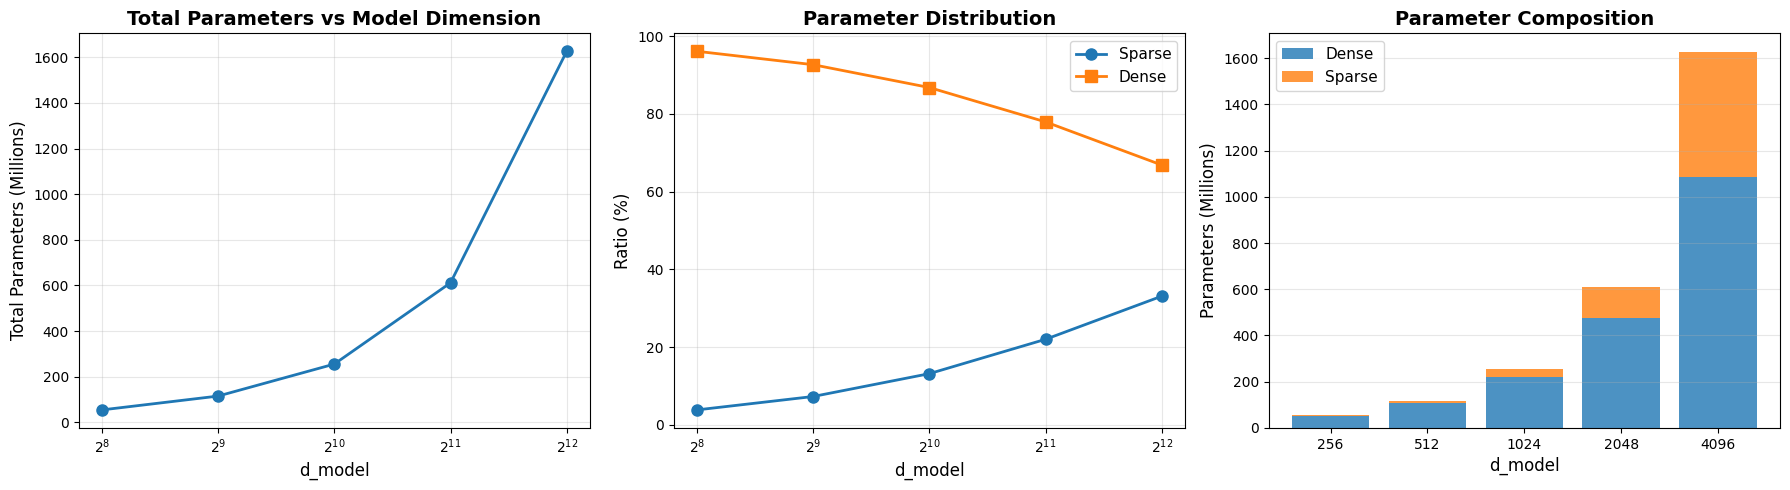

2025-10-17 13:54:09,802 INFO Total parameter range: 54.36M - 1626.68M
2025-10-17 13:54:09,805 INFO Sparse ratio range: 3.873% - 33.133%
2025-10-17 13:54:09,806 INFO Dense ratio range: 66.867% - 96.127%
2025-10-17 13:54:09,805 INFO Sparse ratio range: 3.873% - 33.133%
2025-10-17 13:54:09,806 INFO Dense ratio range: 66.867% - 96.127%


In [5]:
# --- Visualization: Scaling by Model Dimension ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Total Parameters vs d_model
axes[0].plot(
    results_df["d_model"],
    results_df["total_params"] / 1e6,
    marker="o",
    linewidth=2,
    markersize=8,
)
axes[0].set_xlabel("d_model", fontsize=12)
axes[0].set_ylabel("Total Parameters (Millions)", fontsize=12)
axes[0].set_title("Total Parameters vs Model Dimension", fontsize=14, fontweight="bold")
axes[0].grid(visible=True, alpha=0.3)
axes[0].set_xscale("log", base=2)

# Plot 2: Sparse and Dense Ratios
axes[1].plot(
    results_df["d_model"],
    results_df["sparse_ratio"] * 100,
    marker="o",
    label="Sparse",
    linewidth=2,
    markersize=8,
)
axes[1].plot(
    results_df["d_model"],
    results_df["dense_ratio"] * 100,
    marker="s",
    label="Dense",
    linewidth=2,
    markersize=8,
)
axes[1].set_xlabel("d_model", fontsize=12)
axes[1].set_ylabel("Ratio (%)", fontsize=12)
axes[1].set_title("Parameter Distribution", fontsize=14, fontweight="bold")
axes[1].legend(fontsize=11)
axes[1].grid(visible=True, alpha=0.3)
axes[1].set_xscale("log", base=2)

# Plot 3: Stacked Bar Chart
x_pos = np.arange(len(results_df))
sparse_params = results_df["total_params"] * results_df["sparse_ratio"] / 1e6
dense_params = results_df["total_params"] * results_df["dense_ratio"] / 1e6

axes[2].bar(x_pos, dense_params, label="Dense", alpha=0.8)
axes[2].bar(x_pos, sparse_params, bottom=dense_params, label="Sparse", alpha=0.8)
axes[2].set_xlabel("d_model", fontsize=12)
axes[2].set_ylabel("Parameters (Millions)", fontsize=12)
axes[2].set_title("Parameter Composition", fontsize=14, fontweight="bold")
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(results_df["d_model"])
axes[2].legend(fontsize=11)
axes[2].grid(visible=True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Log summary statistics
log.info(
    "Total parameter range: %.2fM - %.2fM",
    results_df["total_params"].min() / 1e6,
    results_df["total_params"].max() / 1e6,
)
log.info(
    "Sparse ratio range: %.3f%% - %.3f%%",
    results_df["sparse_ratio"].min() * 100,
    results_df["sparse_ratio"].max() * 100,
)
log.info(
    "Dense ratio range: %.3f%% - %.3f%%",
    results_df["dense_ratio"].min() * 100,
    results_df["dense_ratio"].max() * 100,
)

In [6]:
# --- Scaling by Number of Layers (n_layers) ---
# Analyze how total parameters and ratios change with n_layers
n_layers_list = [4, 16, 32, 64, 128]
results = []
for n_layers in n_layers_list:
    tmp_config = base_config.copy()
    tmp_config["n_layers"] = n_layers
    total_params = get_total_parameters(**tmp_config)
    sparse_ratio = get_sparse_ratio(**tmp_config)
    dense_ratio = get_dense_ratio(**tmp_config)
    results.append(
        {
            "n_layers": n_layers,
            "total_params": total_params,
            "sparse_ratio": sparse_ratio,
            "dense_ratio": dense_ratio,
        },
    )
    log.info(
        "n_layers=%d, total_params=%d, sparse_ratio=%.4f, dense_ratio=%.4f",
        n_layers,
        total_params,
        sparse_ratio,
        dense_ratio,
    )

df_layers = pd.DataFrame(results)
log.info("Layer scaling results:\n%s", df_layers)

2025-10-17 13:54:09,812 INFO n_layers=4, total_params=54358784, sparse_ratio=0.0387, dense_ratio=0.9613
2025-10-17 13:54:09,813 INFO n_layers=16, total_params=63820544, sparse_ratio=0.1320, dense_ratio=0.8680
2025-10-17 13:54:09,813 INFO n_layers=32, total_params=76436224, sparse_ratio=0.2204, dense_ratio=0.7796
2025-10-17 13:54:09,814 INFO n_layers=64, total_params=101667584, sparse_ratio=0.3313, dense_ratio=0.6687
2025-10-17 13:54:09,814 INFO n_layers=128, total_params=152130304, sparse_ratio=0.4429, dense_ratio=0.5571
2025-10-17 13:54:09,815 INFO Layer scaling results:
   n_layers  total_params  sparse_ratio  dense_ratio
0         4      54358784      0.038731     0.961269
1        16      63820544      0.131954     0.868046
2        32      76436224      0.220350     0.779650
3        64     101667584      0.331330     0.668670
4       128     152130304      0.442851     0.557149
2025-10-17 13:54:09,813 INFO n_layers=16, total_params=63820544, sparse_ratio=0.1320, dense_ratio=0.868

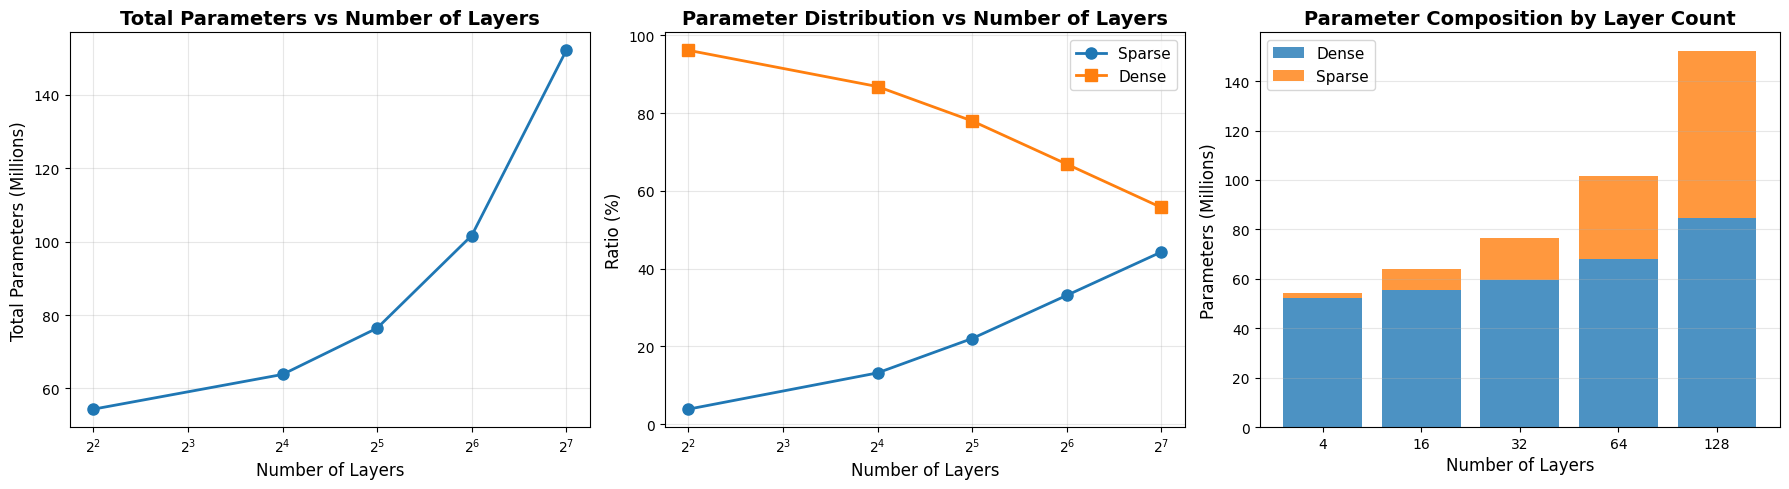

2025-10-17 13:54:10,101 INFO Total parameter range: 54.36M - 152.13M
2025-10-17 13:54:10,102 INFO Sparse ratio range: 3.873% - 44.285%
2025-10-17 13:54:10,103 INFO Dense ratio range: 55.715% - 96.127%
2025-10-17 13:54:10,102 INFO Sparse ratio range: 3.873% - 44.285%
2025-10-17 13:54:10,103 INFO Dense ratio range: 55.715% - 96.127%


In [7]:
# --- Visualization: Scaling by Number of Layers ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Total Parameters vs n_layers
axes[0].plot(
    df_layers["n_layers"],
    df_layers["total_params"] / 1e6,
    marker="o",
    linewidth=2,
    markersize=8,
)
axes[0].set_xlabel("Number of Layers", fontsize=12)
axes[0].set_ylabel("Total Parameters (Millions)", fontsize=12)
axes[0].set_title(
    "Total Parameters vs Number of Layers",
    fontsize=14,
    fontweight="bold",
)
axes[0].grid(visible=True, alpha=0.3)
axes[0].set_xscale("log", base=2)

# Plot 2: Sparse and Dense Ratios
axes[1].plot(
    df_layers["n_layers"],
    df_layers["sparse_ratio"] * 100,
    marker="o",
    label="Sparse",
    linewidth=2,
    markersize=8,
)
axes[1].plot(
    df_layers["n_layers"],
    df_layers["dense_ratio"] * 100,
    marker="s",
    label="Dense",
    linewidth=2,
    markersize=8,
)
axes[1].set_xlabel("Number of Layers", fontsize=12)
axes[1].set_ylabel("Ratio (%)", fontsize=12)
axes[1].set_title(
    "Parameter Distribution vs Number of Layers",
    fontsize=14,
    fontweight="bold",
)
axes[1].legend(fontsize=11)
axes[1].grid(visible=True, alpha=0.3)
axes[1].set_xscale("log", base=2)

# Plot 3: Stacked Bar Chart
x_pos = np.arange(len(df_layers))
sparse_params = df_layers["total_params"] * df_layers["sparse_ratio"] / 1e6
dense_params = df_layers["total_params"] * df_layers["dense_ratio"] / 1e6

axes[2].bar(x_pos, dense_params, label="Dense", alpha=0.8)
axes[2].bar(x_pos, sparse_params, bottom=dense_params, label="Sparse", alpha=0.8)
axes[2].set_xlabel("Number of Layers", fontsize=12)
axes[2].set_ylabel("Parameters (Millions)", fontsize=12)
axes[2].set_title(
    "Parameter Composition by Layer Count",
    fontsize=14,
    fontweight="bold",
)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(df_layers["n_layers"])
axes[2].legend(fontsize=11)
axes[2].grid(visible=True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Log summary statistics
log.info(
    "Total parameter range: %.2fM - %.2fM",
    df_layers["total_params"].min() / 1e6,
    df_layers["total_params"].max() / 1e6,
)
log.info(
    "Sparse ratio range: %.3f%% - %.3f%%",
    df_layers["sparse_ratio"].min() * 100,
    df_layers["sparse_ratio"].max() * 100,
)
log.info(
    "Dense ratio range: %.3f%% - %.3f%%",
    df_layers["dense_ratio"].min() * 100,
    df_layers["dense_ratio"].max() * 100,
)

In [8]:
# --- Combined Scaling: d_model and n_layers ---
# Analyze parameter composition for specific (d_model, n_layers) pairs
overwrite_confs = [
    (256, 4),
    (512, 16),
    (1024, 32),
    (2048, 64),
    (4096, 128),
]
results = []
for d_model, n_layers in overwrite_confs:
    tmp_config = base_config.copy()
    tmp_config["d_model"] = d_model
    tmp_config["n_layers"] = n_layers
    tmp_config["n_experts"] = 4 * d_model // 128
    total_params = get_total_parameters(**tmp_config)
    sparse_ratio = get_sparse_ratio(**tmp_config)
    dense_ratio = get_dense_ratio(**tmp_config)
    results.append(
        {
            "d_model": d_model,
            "n_layers": n_layers,
            "n_experts": tmp_config["n_experts"],
            "total_params": total_params,
            "sparse_ratio": sparse_ratio,
            "dense_ratio": dense_ratio,
        },
    )
    log.info(
        "d_model=%d, n_layers=%d, n_experts=%d, total_params=%d,"
        " sparse_ratio=%.4f, dense_ratio=%.4f",
        d_model,
        n_layers,
        tmp_config["n_experts"],
        total_params,
        sparse_ratio,
        dense_ratio,
    )

df_combined = pd.DataFrame(results)
log.info("Combined scaling results:\n%s", df_combined)

2025-10-17 13:54:10,112 INFO d_model=256, n_layers=4, n_experts=8, total_params=54358784, sparse_ratio=0.0387, dense_ratio=0.9613
2025-10-17 13:54:10,112 INFO d_model=512, n_layers=16, n_experts=16, total_params=152872448, sparse_ratio=0.2204, dense_ratio=0.7796
2025-10-17 13:54:10,113 INFO d_model=1024, n_layers=32, n_experts=32, total_params=608521216, sparse_ratio=0.4429, dense_ratio=0.5571
2025-10-17 13:54:10,113 INFO d_model=2048, n_layers=64, n_experts=64, total_params=3639252992, sparse_ratio=0.5924, dense_ratio=0.4076
2025-10-17 13:54:10,114 INFO d_model=4096, n_layers=128, n_experts=128, total_params=26656190464, sparse_ratio=0.6470, dense_ratio=0.3530
2025-10-17 13:54:10,115 INFO Combined scaling results:
   d_model  n_layers  n_experts  total_params  sparse_ratio  dense_ratio
0      256         4          8      54358784      0.038731     0.961269
1      512        16         16     152872448      0.220350     0.779650
2     1024        32         32     608521216      0.442

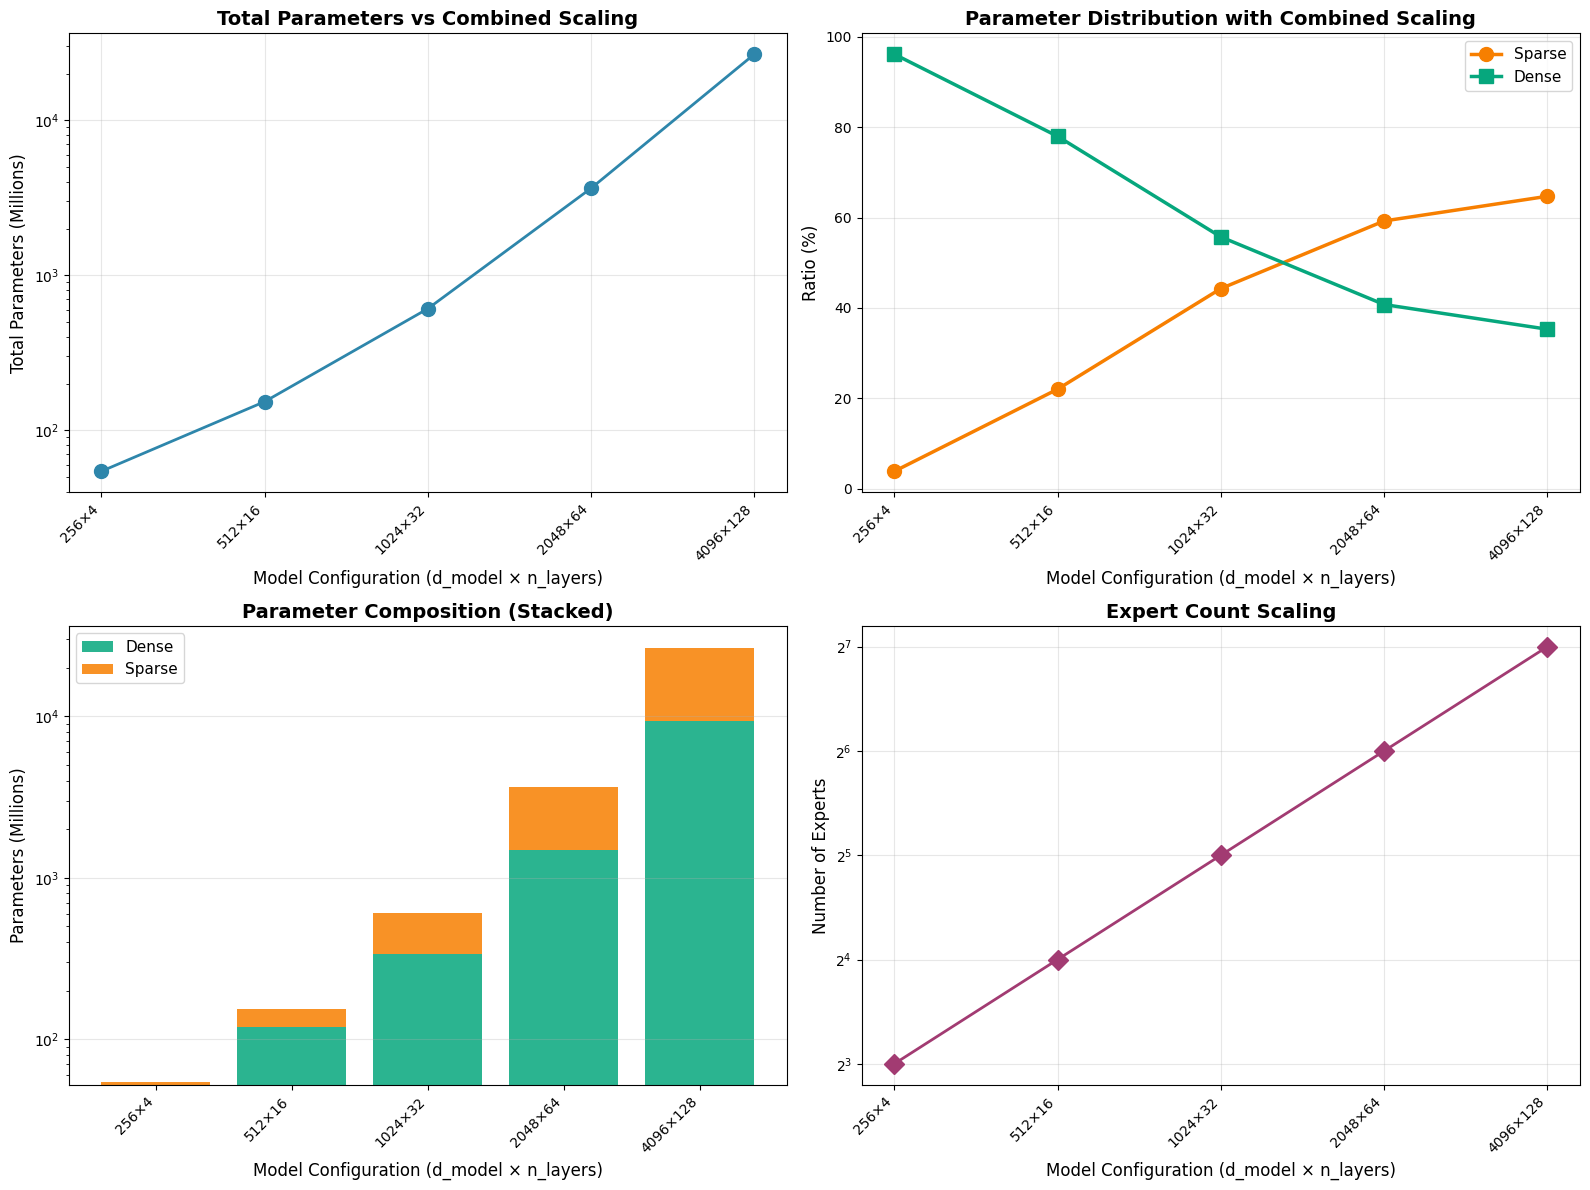

2025-10-17 13:54:10,651 INFO Detailed Summary Statistics:
2025-10-17 13:54:10,653 INFO Configuration: d_model=256, n_layers=4, n_experts=8
2025-10-17 13:54:10,654 INFO   Total Parameters: 54.36M (0.05B)
2025-10-17 13:54:10,654 INFO   Sparse Ratio: 3.87%
2025-10-17 13:54:10,655 INFO   Dense Ratio: 96.13%
2025-10-17 13:54:10,655 INFO Configuration: d_model=512, n_layers=16, n_experts=16
2025-10-17 13:54:10,656 INFO   Total Parameters: 152.87M (0.15B)
2025-10-17 13:54:10,656 INFO   Sparse Ratio: 22.04%
2025-10-17 13:54:10,657 INFO   Dense Ratio: 77.96%
2025-10-17 13:54:10,657 INFO Configuration: d_model=1024, n_layers=32, n_experts=32
2025-10-17 13:54:10,658 INFO   Total Parameters: 608.52M (0.61B)
2025-10-17 13:54:10,658 INFO   Sparse Ratio: 44.29%
2025-10-17 13:54:10,658 INFO   Dense Ratio: 55.71%
2025-10-17 13:54:10,659 INFO Configuration: d_model=2048, n_layers=64, n_experts=64
2025-10-17 13:54:10,659 INFO   Total Parameters: 3639.25M (3.64B)
2025-10-17 13:54:10,660 INFO   Sparse Rati

In [9]:
# --- Visualization: Combined Scaling ---


fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_labels = [
    f"{d}×{n}"  # noqa: RUF001
    for d, n in zip(df_combined["d_model"], df_combined["n_layers"], strict=True)
]

# Plot 1: Total Parameters (log scale)
axes[0, 0].plot(
    range(len(df_combined)),
    df_combined["total_params"] / 1e6,
    marker="o",
    linewidth=2,
    markersize=10,
    color="#2E86AB",
)
axes[0, 0].set_xlabel(
    "Model Configuration (d_model × n_layers)",  # noqa: RUF001
    fontsize=12,
)
axes[0, 0].set_ylabel("Total Parameters (Millions)", fontsize=12)
axes[0, 0].set_title(
    "Total Parameters vs Combined Scaling",
    fontsize=14,
    fontweight="bold",
)
axes[0, 0].set_xticks(range(len(df_combined)))
axes[0, 0].set_xticklabels(model_labels, rotation=45, ha="right")
axes[0, 0].grid(visible=True, alpha=0.3)
axes[0, 0].set_yscale("log")

# Plot 2: Sparse and Dense Ratios
x_pos = range(len(df_combined))
axes[0, 1].plot(
    x_pos,
    df_combined["sparse_ratio"] * 100,
    marker="o",
    label="Sparse",
    linewidth=2.5,
    markersize=10,
    color="#F77F00",
)
axes[0, 1].plot(
    x_pos,
    df_combined["dense_ratio"] * 100,
    marker="s",
    label="Dense",
    linewidth=2.5,
    markersize=10,
    color="#06A77D",
)
axes[0, 1].set_xlabel(
    "Model Configuration (d_model × n_layers)",  # noqa: RUF001
    fontsize=12,
)
axes[0, 1].set_ylabel("Ratio (%)", fontsize=12)
axes[0, 1].set_title(
    "Parameter Distribution with Combined Scaling",
    fontsize=14,
    fontweight="bold",
)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_labels, rotation=45, ha="right")
axes[0, 1].legend(fontsize=11, loc="best")
axes[0, 1].grid(visible=True, alpha=0.3)

# Plot 3: Stacked Bar Chart
sparse_params = df_combined["total_params"] * df_combined["sparse_ratio"] / 1e6
dense_params = df_combined["total_params"] * df_combined["dense_ratio"] / 1e6

axes[1, 0].bar(x_pos, dense_params, label="Dense", alpha=0.85, color="#06A77D")
axes[1, 0].bar(
    x_pos,
    sparse_params,
    bottom=dense_params,
    label="Sparse",
    alpha=0.85,
    color="#F77F00",
)
axes[1, 0].set_xlabel(
    "Model Configuration (d_model × n_layers)",  # noqa: RUF001
    fontsize=12,
)
axes[1, 0].set_ylabel("Parameters (Millions)", fontsize=12)
axes[1, 0].set_title("Parameter Composition (Stacked)", fontsize=14, fontweight="bold")
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(model_labels, rotation=45, ha="right")
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(visible=True, alpha=0.3, axis="y")
axes[1, 0].set_yscale("log")

# Plot 4: Number of Experts
axes[1, 1].plot(
    range(len(df_combined)),
    df_combined["n_experts"],
    marker="D",
    linewidth=2,
    markersize=10,
    color="#A23B72",
)
axes[1, 1].set_xlabel(
    "Model Configuration (d_model × n_layers)",  # noqa: RUF001
    fontsize=12,
)
axes[1, 1].set_ylabel("Number of Experts", fontsize=12)
axes[1, 1].set_title("Expert Count Scaling", fontsize=14, fontweight="bold")
axes[1, 1].set_xticks(range(len(df_combined)))
axes[1, 1].set_xticklabels(model_labels, rotation=45, ha="right")
axes[1, 1].grid(visible=True, alpha=0.3)
axes[1, 1].set_yscale("log", base=2)

plt.tight_layout()
plt.show()

# Log detailed summary statistics
log.info("Detailed Summary Statistics:")
for _idx, row in df_combined.iterrows():
    log.info(
        "Configuration: d_model=%d, n_layers=%d, n_experts=%d",
        row["d_model"],
        row["n_layers"],
        row["n_experts"],
    )
    log.info(
        "  Total Parameters: %.2fM (%.2fB)",
        row["total_params"] / 1e6,
        row["total_params"] / 1e9,
    )
    log.info("  Sparse Ratio: %.2f%%", row["sparse_ratio"] * 100)
    log.info("  Dense Ratio: %.2f%%", row["dense_ratio"] * 100)
log.info(
    "Parameter growth: %.2fM → %.2fB (%.1fx increase)",
    df_combined["total_params"].iloc[0] / 1e6,
    df_combined["total_params"].iloc[-1] / 1e9,
    df_combined["total_params"].iloc[-1] / df_combined["total_params"].iloc[0],
)
log.info(
    "Sparse ratio growth: %.2f%% → %.2f%%",
    df_combined["sparse_ratio"].iloc[0] * 100,
    df_combined["sparse_ratio"].iloc[-1] * 100,
)

---

## Conclusion

This notebook provides a comprehensive analysis of how model dimension, layer count, and expert count affect parameter composition in sparse and dense architectures. The visualizations and logged statistics can guide model design and scaling decisions for large language models.

For further analysis, see `completep_scaling.ipynb` for additional scaling experiments and logging best practices.